# Tutorial: Learning for OU process with Neural GSDE

In this tutorial, we will walk through the process of setting up and testing Neural ODE, Neural CDE, and different formulation of Neural SDE models for a regression task using simulation data generated from an Ornstein-Uhlenbeck (OU) process.

### Step 1: Generate OU Process Data

The Ornstein-Uhlenbeck (OU) process is a type of stochastic differential equation (SDE) commonly used in financial mathematics and other fields. The OU process is defined by the following SDE:

$$ dX_t = \theta (\mu - X_t) \, dt + \sigma \, dW_t $$

where:
- $\theta$ is the mean reversion rate,
- $\mu$ is the long-term mean,
- $\sigma$ is the volatility,
- $W_t$ is a Wiener process (or Brownian motion).

Let's generate data using the OU process:

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchcde
import torchsde
from torch.utils.data import Dataset, DataLoader

# Setup seed for reproducibility
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
def ou_process(T, N, theta, mu, sigma, X0):
    """
    Simulate the Ornstein-Uhlenbeck process.

    Parameters:
    T (float): Total time.
    N (int): Number of time steps.
    theta (float): Rate of mean reversion.
    mu (float): Long-term mean.
    sigma (float): Volatility.
    X0 (float): Initial value.

    Returns:
    np.ndarray: Simulated values of the OU process.
    """
    dt = T / N
    t = np.linspace(0, T, N)
    X = np.zeros(N)
    X[0] = X0

    for i in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        X[i] = X[i-1] + theta * (mu - X[i-1]) * dt + sigma * dW

    return t, X

def generate_data(num_samples, T, N, theta, mu, sigma, X0):
    data_list = []
    for _ in range(num_samples):
        t, X = ou_process(T, N, theta, mu, sigma, X0)
        data_list.append([t, X])

    total_data = torch.Tensor(np.array(data_list))  # [Batch size, Dimension, Length]
    total_data = total_data.permute(0, 2, 1)  # [Batch size, Length, Dimension]

    max_len = total_data.shape[1]
    times = torch.linspace(0, 1, max_len)
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(total_data, times)

    return total_data, coeffs, times

class OU_Dataset(Dataset):
    def __init__(self, data, coeffs):
        self.data = data
        self.coeffs = coeffs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            self.data[idx, ...],
            self.coeffs[idx, ...],
        )

def split_data(data, coeffs, train_ratio=0.8):
    total_size = len(data)
    train_size = int(total_size * train_ratio)

    train_idx = np.random.choice(range(total_size), train_size, replace=False)
    test_idx = np.array([i for i in range(total_size) if i not in train_idx])

    train_data = data[train_idx, ...]
    test_data = data[test_idx, ...]
    train_coeffs = coeffs[train_idx, ...]
    test_coeffs = coeffs[test_idx, ...]

    return train_data, train_coeffs, test_data, test_coeffs

def create_data_loaders(train_data, train_coeffs, test_data, test_coeffs, batch_size=16):
    train_dataset = OU_Dataset(train_data, train_coeffs)
    test_dataset = OU_Dataset(test_data, test_coeffs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

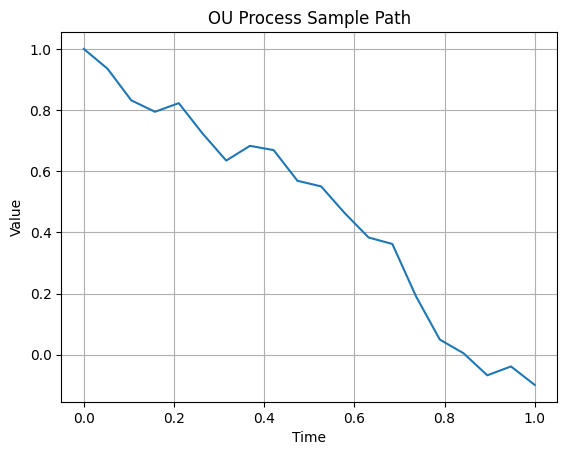

In [3]:
# Parameters
config = {
    'num_samples': 1000,
    'T': 10.0,
    'N': 20,
    'theta': 0.2,
    'mu': 0.0,
    'sigma': 0.1,
    'X0': 1.0,
    'train_ratio': 0.8,
    'batch_size': 16,
    'seed': 42
}

# Ensure reproducibility
seed_everything(config['seed'])

# Generate data
total_data, coeffs, times = generate_data(config['num_samples'], config['T'], config['N'], config['theta'], config['mu'], config['sigma'], config['X0'])

# Split data
train_data, train_coeffs, test_data, test_coeffs = split_data(total_data, coeffs, config['train_ratio'])

# Create data loaders
train_loader, test_loader = create_data_loaders(train_data, train_coeffs, test_data, test_coeffs, config['batch_size'])

# Plot the first sample for verification
plt.plot(times.numpy(), total_data[0, :, 1].numpy())
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('OU Process Sample Path')
plt.grid('on')
plt.show()

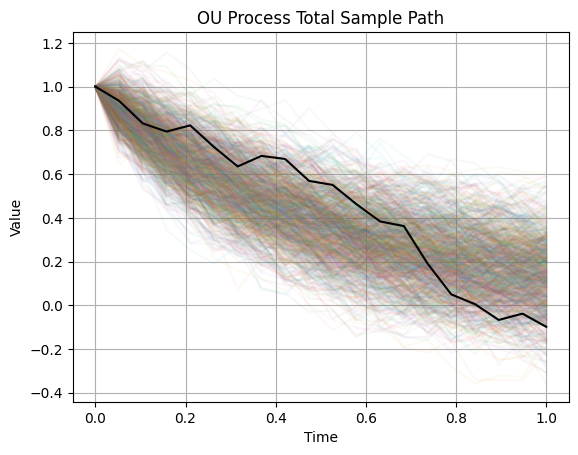

In [4]:
# Plot the whole samples for verification
for data in total_data:
    plt.plot(times.numpy(), data[:,1].numpy(), alpha=0.05)
plt.plot(times.numpy(), total_data[0, :, 1].numpy(), color='k')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('OU Process Total Sample Path')
plt.grid('on')
plt.show()

### Step 2: Define model

We can define Neural Geometric SDE (GSDE) as follows:

$$
\frac{dz(t)}{z(t)} = \gamma(t, \tilde{z}(t); \theta_\gamma) \, dt + \sigma(t; \theta_\sigma) \, dW_t
$$

Please refer original paper for the details: [https://arxiv.org/pdf/2402.14989](https://arxiv.org/pdf/2402.14989)

In [5]:
class LipSwish(nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)

class MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_dim, num_layers, tanh=False, activation='relu'):
        super().__init__()

        if activation == 'lipswish':
            activation_fn = LipSwish()
        else:
            activation_fn = nn.ReLU()

        model = [nn.Linear(in_size, hidden_dim), activation_fn]
        for _ in range(num_layers - 1):
            model.append(nn.Linear(hidden_dim, hidden_dim))
            model.append(activation_fn)
        model.append(nn.Linear(hidden_dim, out_size))
        if tanh:
            model.append(nn.Tanh())
        self._model = nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

class NeuralGSDEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, activation='relu'):
        super(NeuralGSDEFunc, self).__init__()
        self.sde_type = "ito"
        self.noise_type = "diagonal" # or "scalar"

        self.linear_in = nn.Linear(input_dim + 2, input_dim + 1)
        self.linear_X = nn.Linear(2, input_dim + 1)
        self.emb = torch.nn.Linear(input_dim*2 + 2, input_dim + 1)
        self.f_net = MLP(input_dim + 1, input_dim, hidden_dim, num_layers, activation=activation)
        self.noise_in = nn.Linear(2, input_dim + 1)
        self.g_net = MLP(input_dim + 1, input_dim, hidden_dim, num_layers, activation=activation)

    def set_X(self, coeffs, times):
        self.coeffs = coeffs
        self.times = times
        self.X = torchcde.CubicSpline(self.coeffs, self.times)
    
    def f(self, t, y):
        Xt = self.X.evaluate(t)
        Xt = self.linear_X(Xt)

        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        yy = self.linear_in(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))
        z = self.emb(torch.cat([yy,Xt], dim=-1))
        return self.f_net(z) * y # (1 - torch.nan_to_num(y).sigmoid())

    def g(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        tt = self.noise_in(torch.cat((torch.sin(t), torch.cos(t)), dim=-1))
        return self.g_net(tt) * y

class NDE_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation='relu', vector_field=None):
        super(NDE_model, self).__init__()
        self.func = vector_field(hidden_dim, hidden_dim, num_layers, activation=activation)
        self.initial = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, coeffs, times):
        # control module
        self.func.set_X(coeffs, times)

        y0 = self.func.X.evaluate(times)
        y0 = self.initial(y0)[:,0,:]

        z = torchsde.sdeint(sde=self.func,
                            y0=y0,
                            ts=times,
                            dt=0.1,
                            method='euler')
        z = z.permute(1,0,2)
        return self.decoder(z)

In [6]:
input_dim = 2
output_dim = 1
hidden_dim = 16
num_layers = 2

model = NDE_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, vector_field=NeuralGSDEFunc).to(device)

In [7]:
num_epochs=100
lr=1e-3

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

Test Loss: 0.9518698224654565


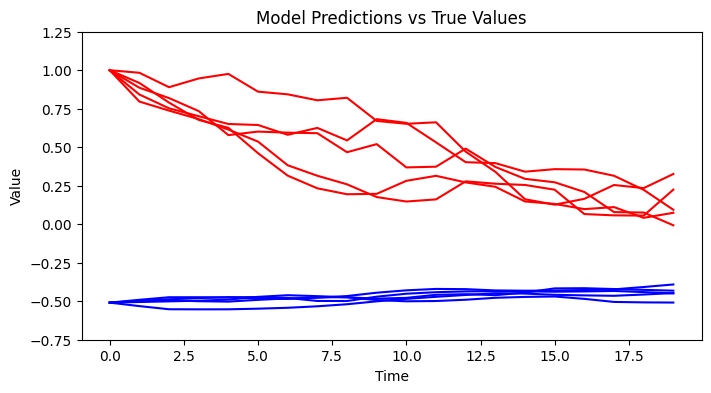

In [8]:
model.eval()
total_loss = 0
all_preds = []
all_trues = []
with torch.no_grad():
    for batch in test_loader:
        coeffs = batch[1].to(device)
        times = torch.linspace(0, 1, batch[0].shape[1]).to(device)

        true = batch[0][:,:,1].to(device)
        pred = model(coeffs, times).squeeze(-1)
        loss = criterion(pred, true)
        total_loss += loss.item()

        all_preds.append(pred.cpu())
        all_trues.append(true.cpu())

avg_loss = total_loss / len(test_loader)
print(f'Test Loss: {avg_loss}')

all_preds = torch.cat(all_preds, dim=0)
all_trues = torch.cat(all_trues, dim=0)

##
num_samples = 5

plt.figure(figsize=(8, 4))
for i in range(num_samples):
    plt.plot(all_trues[i].numpy(), color='r')
    plt.plot(all_preds[i].numpy(), color='b')
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(-0.75,1.25)
plt.title('Model Predictions vs True Values')
plt.show()

Epoch 10, Loss: 0.01868871970102191
Test Loss: 0.018948996296295754


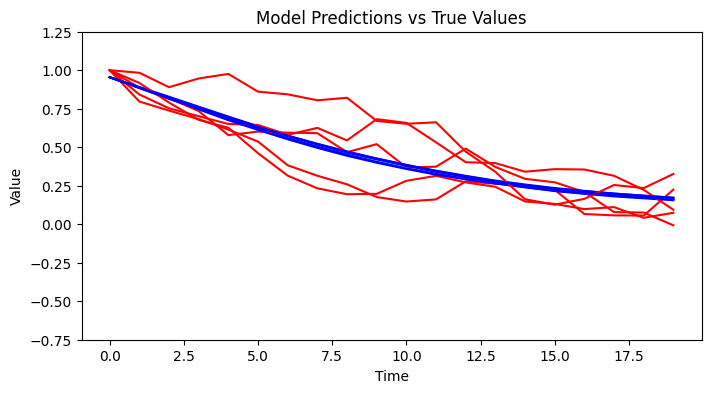

Epoch 20, Loss: 0.01635917566716671
Test Loss: 0.015578625795359794


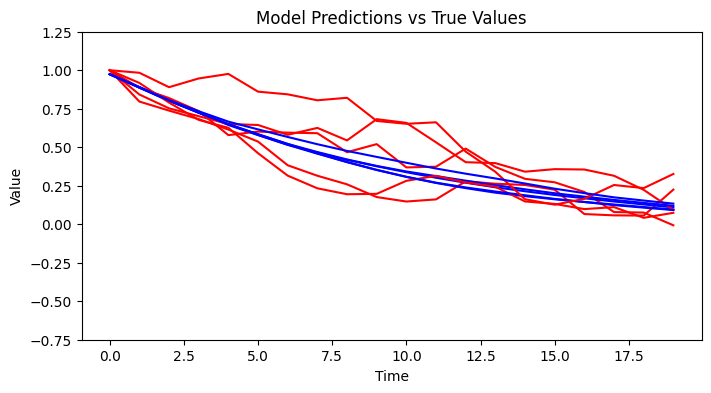

Epoch 30, Loss: 0.010336053920909763
Test Loss: 0.00965106043104942


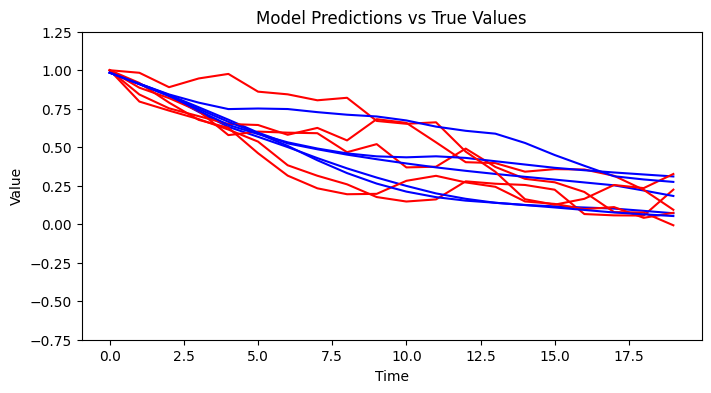

Epoch 40, Loss: 0.007835041172802449
Test Loss: 0.00728972668114763


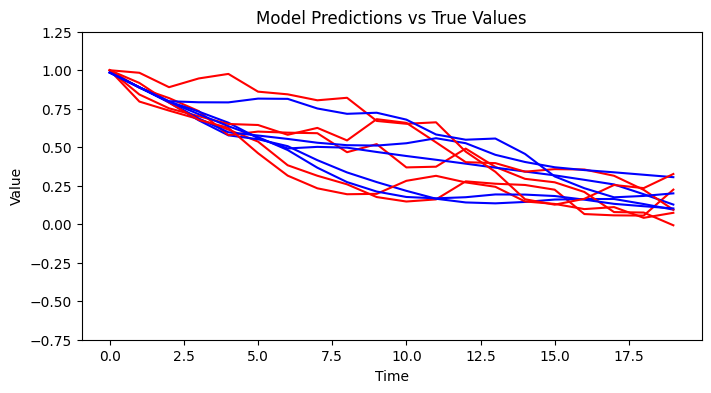

Epoch 50, Loss: 0.006885781921446323
Test Loss: 0.0065295669035269665


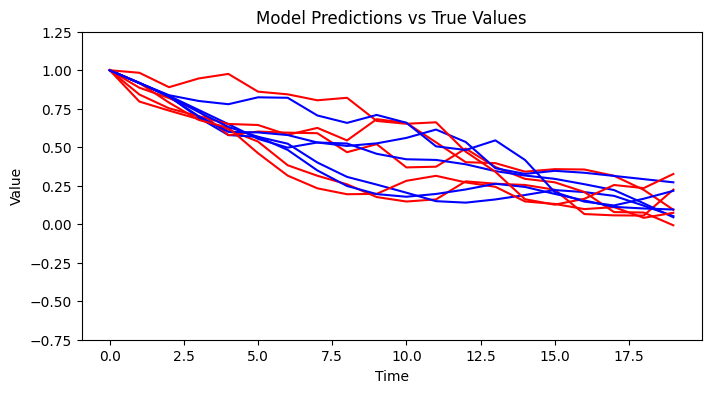

Epoch 60, Loss: 0.00672257955186069
Test Loss: 0.006364395483755148


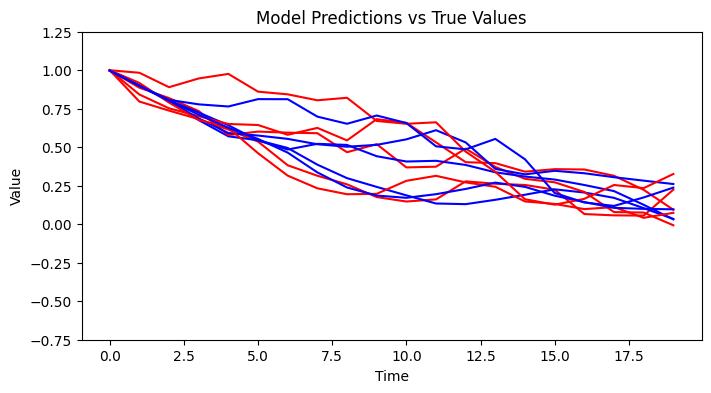

Epoch 70, Loss: 0.006728752516210079
Test Loss: 0.0068107718028701265


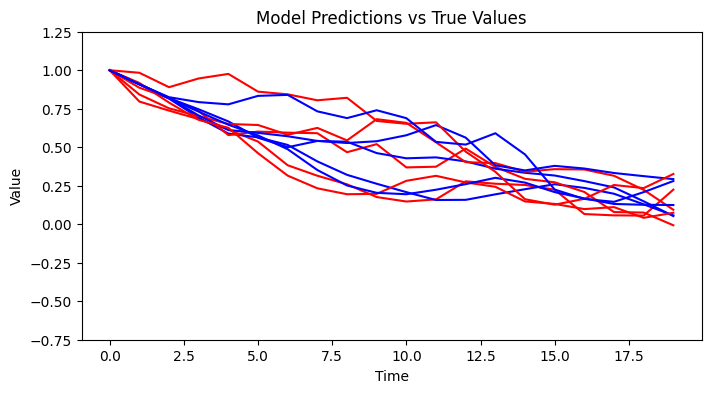

Epoch 80, Loss: 0.006694352971389889
Test Loss: 0.006380862234017024


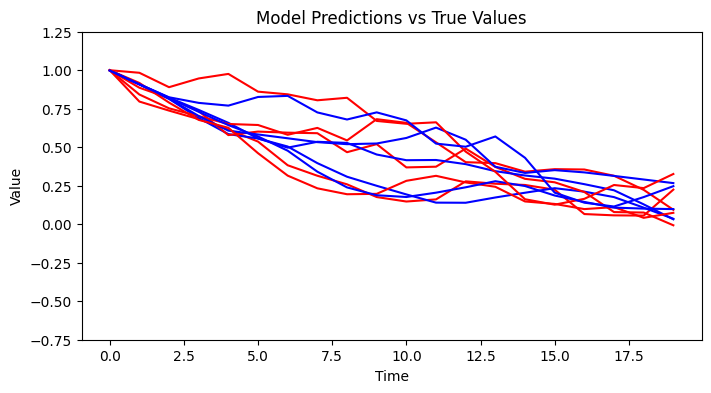

Epoch 90, Loss: 0.006772488430142403
Test Loss: 0.006310612214012788


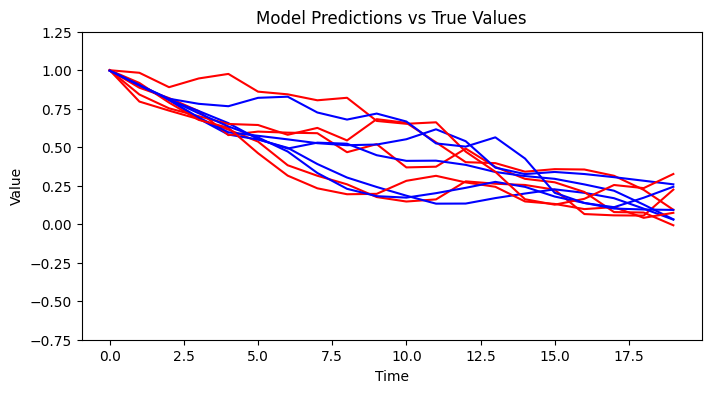

Epoch 100, Loss: 0.006683066077530384
Test Loss: 0.0065970259646956735


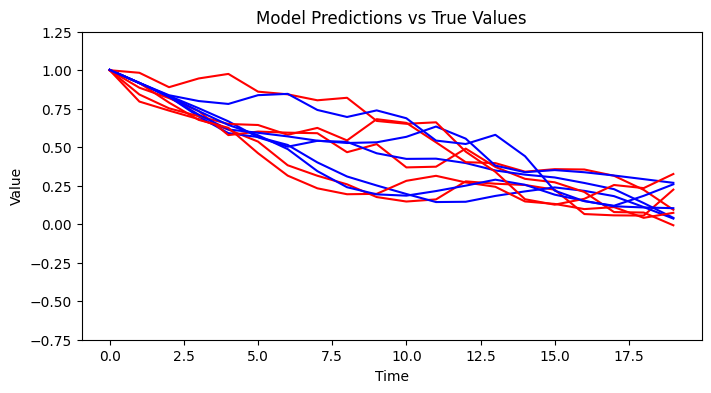

In [9]:
for epoch in range(1,num_epochs+1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        coeffs = batch[1].to(device)
        times = torch.linspace(0, 1, batch[0].shape[1]).to(device)

        optimizer.zero_grad()
        true = batch[0][:,:,1].to(device)
        pred = model(coeffs, times).squeeze(-1)
        loss = criterion(pred, true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch}, Loss: {avg_loss}')

        ##
        model.eval()
        total_loss = 0
        all_preds = []
        all_trues = []
        with torch.no_grad():
            for batch in test_loader:
                coeffs = batch[1].to(device)
                times = torch.linspace(0, 1, batch[0].shape[1]).to(device)
        
                true = batch[0][:,:,1].to(device)
                pred = model(coeffs, times).squeeze(-1)
                loss = criterion(pred, true)
                total_loss += loss.item()
        
                all_preds.append(pred.cpu())
                all_trues.append(true.cpu())
        
        avg_loss = total_loss / len(test_loader)
        print(f'Test Loss: {avg_loss}')
        
        all_preds = torch.cat(all_preds, dim=0)
        all_trues = torch.cat(all_trues, dim=0)
    
        ##      
        plt.figure(figsize=(8, 4))
        for i in range(num_samples):
            plt.plot(all_trues[i].numpy(), color='r')
            plt.plot(all_preds[i].numpy(), color='b')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.ylim(-0.75,1.25)
        plt.title('Model Predictions vs True Values')
        plt.show()

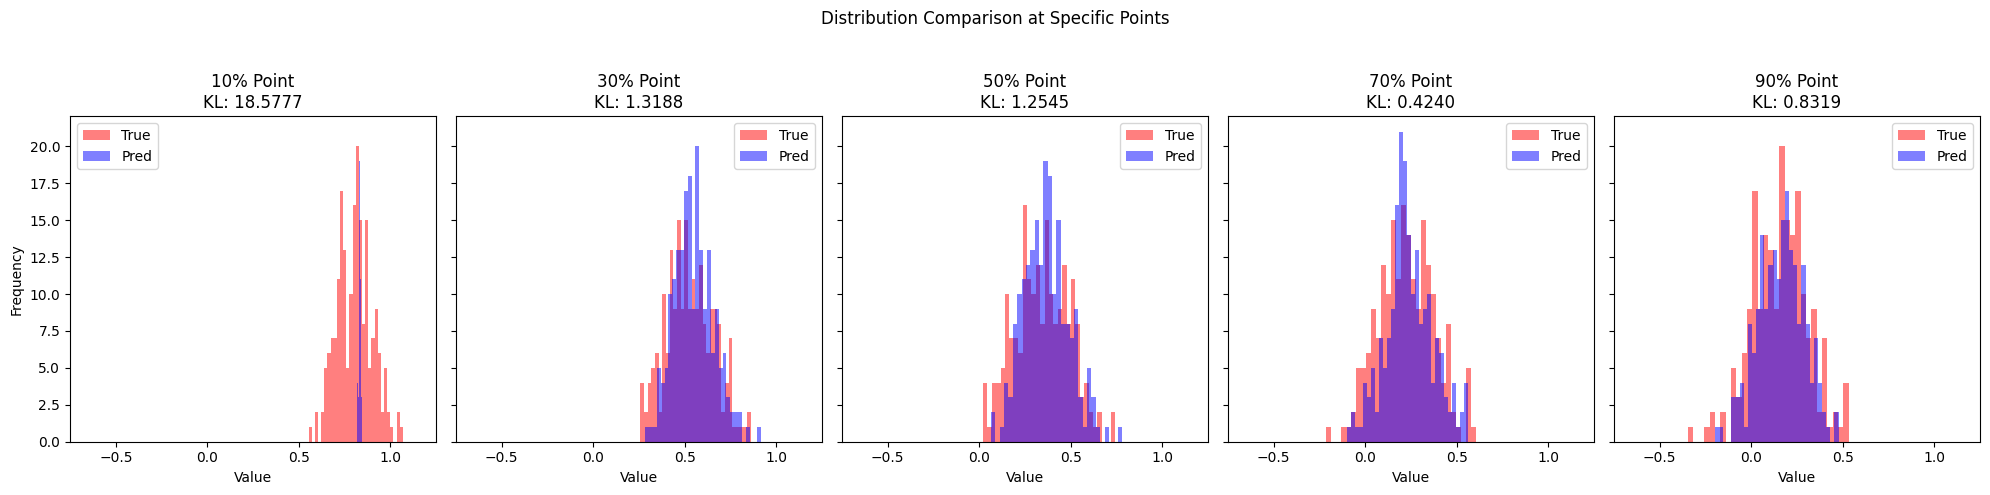

In [10]:
from scipy.stats import entropy

def calculate_kl_divergence(true_values, pred_values, num_bins=30):
    # Compute histogram for true and predicted values
    hist_true, bin_edges = np.histogram(true_values, bins=num_bins, density=True)
    hist_pred, _ = np.histogram(pred_values, bins=bin_edges, density=True)

    # Avoid division by zero and log(0) issues
    hist_true = np.where(hist_true == 0, 1e-10, hist_true)
    hist_pred = np.where(hist_pred == 0, 1e-10, hist_pred)

    # Calculate KL divergence
    kl_div = entropy(hist_true, hist_pred)
    return kl_div

def compare_distributions(true_data, pred_data, points, num_bins=30):
    time_points = [int(p * true_data.shape[1]) for p in points]
    
    fig, axes = plt.subplots(1, len(points), figsize=(20, 5), sharey=True)
    
    for ax, point, time_point in zip(axes, points, time_points):
        true_values = true_data[:, time_point].numpy()
        pred_values = pred_data[:, time_point].numpy()
        
        kl_div = calculate_kl_divergence(true_values, pred_values, num_bins)
        
        ax.hist(true_values, bins=num_bins, alpha=0.5, label='True', color='r')
        ax.hist(pred_values, bins=num_bins, alpha=0.5, label='Pred', color='b')
        ax.set_title(f'{int(point * 100)}% Point\nKL: {kl_div:.4f}')
        ax.set_xlabel('Value')
        ax.set_xlim(-0.75,1.25)
        ax.set_xticks([-0.5,0.0,0.5,1.0])
        if ax == axes[0]:
            ax.set_ylabel('Frequency')
        ax.legend()

    plt.suptitle('Distribution Comparison at Specific Points')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

points_to_compare = [0.1, 0.3, 0.5, 0.7, 0.9]
compare_distributions(all_trues, all_preds, points_to_compare)